In [52]:
import pandas as pd
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from scipy.stats import vonmises
from scipy.optimize import minimize

In [4]:
# @title Basic plots of subject estimate average by task conditions

# circular statistics utils
# -------------------
def get_cartesian_to_deg(x: np.ndarray, y: np.ndarray, signed: bool) -> np.ndarray:
    """convert cartesian coordinates to
    angles in degree
    Args:
        x (np.ndarray): x coordinate
        y (np.ndarray): y coordinate
        signed (boolean): True (signed) or False (unsigned)
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_cartesian_to_deg
            x = np.array([1, 0, -1, 0])
            y = np.array([0, 1, 0, -1])
            degree = get_cartesian_to_deg(x,y,False)
            # Out: array([  0.,  90., 180., 270.])
    Returns:
        np.ndarray: angles in degree
    """
    # convert to radian (ignoring divide by 0 warning)
    with np.errstate(divide="ignore"):
        degree = np.arctan(y / x)

    # convert to degree and adjust based
    # on quadrant
    for ix in range(len(x)):
        if (x[ix] >= 0) and (y[ix] >= 0):
            degree[ix] = degree[ix] * 180 / np.pi
        elif (x[ix] == 0) and (y[ix] == 0):
            degree[ix] = 0
        elif x[ix] < 0:
            degree[ix] = degree[ix] * 180 / np.pi + 180
        elif (x[ix] >= 0) and (y[ix] < 0):
            degree[ix] = degree[ix] * 180 / np.pi + 360

    # if needed, convert signed to unsigned
    if not signed:
        degree[degree < 0] = degree[degree < 0] + 360
    return degree


def get_deg_to_rad(deg: np.array, signed: bool):
    """convert angles in degree to radian
    Args:
        deg (np.array): angles in degree
        signed (bool): True (signed) or False (unsigned)
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_deg_to_rad
            radians = get_deg_to_rad(np.array([0, 90, 180, 270], True)
            Out: array([ 0., 1.57079633, 3.14159265, -1.57079633])
    Returns:
        np.ndarray: angles in radian
    """
    # get unsigned radians (1:2*pi)
    rad = (deg / 360) * 2 * pi

    # get signed radians(-pi:pi)
    if signed:
        rad[deg > 180] = (deg[deg > 180] - 360) * (2 * pi / 360)
    return rad


def get_polar_to_cartesian(angle: np.ndarray, radius: float, type: str) -> dict:
    """convert angle in degree or radian to cartesian coordinates
    Args:
        angle (np.ndarray): angles in degree or radian
        radius (float): radius
        type (str): "polar" or "radian"
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_polar_to_cartesian
            degree = np.array([0, 90, 180, 270])
            cartesian = get_polar_to_cartesian(degree, 1, "polar")
            cartesian.keys()

            # Out: dict_keys(['deg', 'rad', 'cart'])

            cartesian["cart"]

            # Out: array([[ 1.,  0.],
            #            [ 0.,  1.],
            #            [-1.,  0.],
            #            [-0., -1.]])
    Returns:
        dict: _description_
    """
    # convert to radian if needed
    theta = dict()
    if type == "polar":
        theta["deg"] = angle
        theta["rad"] = angle * np.pi / 180
    elif type == "radian":
        theta["deg"] = get_deg_to_rad(angle, False)
        theta["rad"] = angle

    # convert to cartesian coordinates
    x = radius * np.cos(theta["rad"])
    y = radius * np.sin(theta["rad"])

    # round to 10e-4
    x = np.round(x, 4)
    y = np.round(y, 4)

    # reshape as (N angles x 2 coord)
    theta["cart"] = np.vstack([x, y]).T
    return theta


def get_circ_weighted_mean_std(angle: np.ndarray, proba: np.ndarray, type: str) -> dict:
    """calculate circular data statistics
    Args:
        angle (np.ndarray): angles in degree or cartesian coordinates
        proba (np.ndarray): each angle's probability of occurrence
        type (str): "polar" or "cartesian"
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_circ_weighted_mean_std
            degree = np.array([358, 0, 2, 88, 90, 92])
            proba = np.array([1, 1, 1, 1, 1, 1])/6
            output = get_circ_weighted_mean_std(degree, proba, "polar")
            output.keys()
            # Out: dict_keys(['coord_all', 'deg_all', 'coord_mean', 'deg_mean',
            #               'deg_all_for_std', 'deg_mean_for_std', 'deg_var',
            #               'deg_std', 'deg_sem'])
            output["deg_mean"]
            # Out: array([45.])
            output["deg_std"]
            # array([45.02961988])
    Returns:
        (dict): angle summary statistics (mean, std, var, sem)

    Raises:
        ValueError: type is not "polar" or "cartesian"
    """

    angle = angle.copy()

    # if polar, convert to cartesian
    if type == "polar":
        radius = 1
        coord = get_polar_to_cartesian(angle, radius=radius, type="polar")
    elif type == "cartesian":
        coord = angle
    else:
        raise ValueError(""" "type" can either be "polar" or "cartesian" value """)

    # store angles
    data = dict()
    data["coord_all"] = coord["cart"]
    data["deg_all"] = coord["deg"]

    # calculate mean
    # ..............
    proba_for_mean = np.tile(proba[:, None], 2)
    data["coord_mean"] = np.sum(proba_for_mean * data["coord_all"], 0)
    data["coord_mean"] = data["coord_mean"][:, None]
    data["deg_mean"] = get_cartesian_to_deg(
        data["coord_mean"][0],
        data["coord_mean"][1],
        signed=False,
    )

    # calculate std
    # ..............
    n_data = len(data["deg_all"])
    data["deg_all_for_std"] = data["deg_all"]
    data["deg_mean_for_std"] = np.tile(data["deg_mean"], n_data)

    # apply corrections
    # when 0 <= mean <= 180
    if data["deg_mean"] + 180 <= 360:
        for ix in range(n_data):
            if data["deg_all"][ix] >= data["deg_mean"] + 180:
                data["deg_all_for_std"][ix] = data["deg_all"][ix] - 360
    else:
        # when 180 <= mean <= 360
        for ix in range(n_data):
            if data["deg_all"][ix] <= data["deg_mean"] - 180:
                data["deg_mean_for_std"][ix] = data["deg_mean"] - 360

    # calculate variance, standard deviation and
    # standard error to the mean
    data["deg_var"] = np.array(
        [sum(proba * (data["deg_all_for_std"] - data["deg_mean_for_std"]) ** 2)]
    )
    data["deg_std"] = np.sqrt(data["deg_var"])
    data["deg_sem"] = data["deg_std"] / np.sqrt(n_data)
    return data


def get_signed_angle(origin: np.ndarray, destination: np.ndarray, type: str):
    """get the signed angle difference between origin and destination angles
    Args:
        origin (np.ndarray): origin angle
        destination (np.ndarray): destination angle
        type (str): angle type ("polar", "radian", "cartesian")
    Usage:
        .. code-block:: python
            angle = get_signed_angle(90, 45, 'polar')

            # Out: array([45.])

            angle = get_signed_angle(90, 45, 'radian')
            # Out: array([58.3103779])
            origin = np.array([[0, 1]])
            destination = np.array([[1, 0]])
            angle = get_signed_angle(origin, destination, "cartesian")

            # Out: array([90.])
    Returns:
        (np.ndarray): signed angle differences
    """

    # convert to cartesian coordinates
    if type == "polar" or type == "radian":
        origin_dict = get_polar_to_cartesian(origin, radius=1, type=type)
        destination_dict = get_polar_to_cartesian(destination, radius=1, type=type)
    elif type == "cartesian":
        origin_dict = dict()
        destination_dict = dict()
        origin_dict["cart"] = origin
        destination_dict["cart"] = destination

    # get coordinates
    xV1 = origin_dict["cart"][:, 0]
    yV1 = origin_dict["cart"][:, 1]
    xV2 = destination_dict["cart"][:, 0]
    yV2 = destination_dict["cart"][:, 1]

    # Calculate the angle separating the
    # two vectors in degrees
    angle = -(180 / np.pi) * np.arctan2(xV1 * yV2 - yV1 * xV2, xV1 * xV2 + yV1 * yV2)
    return angle


def get_combination_set(database: np.ndarray):
    """get the set of row combinations

    Args:
        database (np.ndarray): an N-D array

    Returns:
        (np.ndarray, np.ndarray, np.ndarray): `combs` is the set
        of combinations, `b` are the row indices for each combination
        in database, `c` are the rows indices for each combination in
        combs.
    """
    combs, ia, ic = np.unique(
        database,
        return_index=True,
        return_inverse=True,
        axis=0,
    )
    return (combs, ia, ic)


def get_data_stats(data: pd.Series, output: dict):
    """calculate data statistics

    Args:
        data (pd.Series): stimulus feature estimates
        output (dict): ::

            'PestimateGivenModel': estimate probabilities
            'map': max-a-posteriori percepts
            'conditions': task conditions

    Returns:
        (dict): returns data mean and std to output
    """
    # get conditions
    cond = output["conditions"]

    # initialise statistics
    data_mean = []
    data_std = []

    # get set of conditions
    cond_set, ix, _ = get_combination_set(cond)

    # record stats by condition
    for c_i in range(len(cond_set)):
        # find condition's instances
        loc_1 = cond[:, 0] == cond_set[c_i, 0]
        loc_2 = cond[:, 1] == cond_set[c_i, 1]
        loc_3 = cond[:, 2] == cond_set[c_i, 2]

        # get associated data
        data_c_i = data.values[loc_1 & loc_2 & loc_3]

        # set each instance with equal probability
        trial_proba = np.tile(1 / len(data_c_i), len(data_c_i))

        # get statistics
        stats = get_circ_weighted_mean_std(
            data_c_i,
            trial_proba,
            type="polar",
        )

        # record statistics
        data_mean.append(stats["deg_mean"])
        data_std.append(stats["deg_std"])

    # record statistics
    output["data_mean"] = np.array(data_mean)
    output["data_std"] = np.array(data_std)

    # record their condition
    output["conditions"] = cond_set
    return output


# Visualization utils
# -------------------
def plot_mean(
    data_mean: np.ndarray,
    data_std: np.ndarray,
    condition: np.ndarray,
    prior_mode: float,
    centering: bool,
):
    """plot data and prediction mean and std
    for three conditions (x-axis, colors and panels)
    Args:
        data_mean (np.ndarray): data mean by condition
        data_std (np.ndarray): data std by condition
        prediction_mean (np.ndarray): prediction mean by condition
        prediction_std (np.ndarray): prediction std by condition
        condition (np.ndarray): associated conditions
        prior_mode (float): the mode of the prior
        centering (bool): center x-axis or not
    Returns:
        _type_: _description_
    """
    # get condition levels
    levels_1 = np.flip(np.unique(condition[:, 0]))
    levels_2 = np.flip(np.unique(condition[:, 1]))  # sort in decreasing order
    levels_3 = np.unique(condition[:, 2])

    # set x_tick
    x_tick_centered = get_signed_angle(levels_1, prior_mode, "polar")
    x_tick_centered[x_tick_centered == -180] = 180
    i_sort = np.argsort(x_tick_centered)
    x_tick_centered = x_tick_centered[i_sort]
    y_tick_centered = x_tick_centered

    # set colors
    levels_2_color = [
        [0.5, 0, 0],
        [1, 0.2, 0],
        [1, 0.6, 0],
        [0.75, 0.75, 0],
    ]

    plt.figure(figsize=(10, 3))

    # loop over conditions and plot data
    # and prediction stats
    for level2_ix in range(len(levels_2)):
        # set condition 2 in column panels
        plt.subplot(1, len(levels_2), level2_ix + 1)

        # set condition 3 within panels
        for level1_ix in range(len(levels_1)):
            # find condition's instances
            loc_lev1 = condition[:, 0] == levels_1[level1_ix]
            loc_lev2 = condition[:, 1] == levels_2[level2_ix]
            loc_condition = loc_lev2 & loc_lev1

            # center to prior mode
            x_centered = condition[:, 2][loc_condition]
            if centering:
                x_centered = np.round(
                    get_signed_angle(
                        x_centered,
                        prior_mode,
                        "polar",
                    )
                )

            x_centered[x_centered == -180] = 180

            # make 2-D array
            x_centered = x_centered[:, None]

            # sort data stats
            y_data_centered = data_mean[loc_condition]
            y_data_std_centered = data_std[loc_condition]

            # sort all
            i_sort = np.argsort(x_centered.squeeze())
            x_centered = x_centered[i_sort]
            y_data_centered = y_data_centered[i_sort]
            y_data_std_centered = y_data_std_centered[i_sort]

            # To plot estimates mean against circular stimulus
            # feature on a linear space, the raw stimulus feature and
            # estimates mean are normalized to vectorial angles from
            # the prior mode and x and y axes are centered at zero
            # (normalized prior mode) via a circular shift. Rotation
            # angles were then labelled according to their raw values
            # on the circle (e.g., 0, is labelled 225). A mean estimate
            # of 33 degree was calculated for 55 degree which is very far
            # from stimulus feature on the linear space but actually close
            # to stimulus feature on the circular space. We got rid of
            # this visual artifact by expressing both 55 and 33 as the
            # counterclockwise distance to prior mode (e.g., for a prior
            # mode 225 55 becomes 190 instead of 170 and 33 becomes 168).
            # Note that the maximum vectorial angle is >180.
            if (level2_ix == 3) & (not 180 in x_centered):
                # move point at -170? distance to prior at 190? (positive
                # side) and convert values at x=-170? to positive distance
                # relative to prior to improve visualization
                posNeg170 = x_centered == -170
                x_centered[posNeg170] = prior_mode - 170 + 360 - prior_mode
                x_centered[x_centered == 180] = -180
                y_data_centered[posNeg170] = (
                    prior_mode - abs(y_data_centered[posNeg170]) + 360 - prior_mode
                )

                # sort x-axis
                i_sort = np.argsort(x_centered)
                x_centered = x_centered[i_sort]

                # sort y-axis
                y_data_centered = y_data_centered[i_sort]

                # set ticks
                x_tick_centered = x_centered

            # plot data stats
            plt.errorbar(
                x_centered.squeeze(),
                y_data_centered.squeeze(),
                yerr=y_data_std_centered.squeeze(),
                marker="o",
                markersize=7,
                markeredgecolor="w",
                linestyle="None",
                linewidth=1,
                color=levels_2_color[level1_ix],
                ecolor=levels_2_color[level1_ix],
            )
            plt.ylim([-0, 360])
            plt.hlines(prior_mode, -180, 180, linestyle=":")
            plt.xticks([-160, -80, 0, 80, 160], [-160, -80, 0, 80, 160])
            plt.yticks([67, 147, 227, 307, 387], [-160, -80, 0, 80, 160])
            plt.xlabel(
                "Motion direction distance"
                "\n"
                "relative to the prior mean"
                "\n"
                "(deg)"
            )
            if level2_ix == 0:
                plt.ylabel(
                    "Mean estimates distance"
                    "\n"
                    "relative to the prior mean"
                    "\n"
                    "(deg)"
                )
        plt.title(f"{int(levels_2[level2_ix]*100)}% coherence", fontsize=12)
    plt.show()
    return None

In [64]:
# @title Data loading
data = pd.read_csv("data01_direction4priors.csv")
data = pd.DataFrame(data)

In [65]:
data["motion_direction_rad"] = get_deg_to_rad(data["motion_direction"], False)
data["prior_mean_rad"] = get_deg_to_rad(data["prior_mean"], False)

data["estimate_angle_rad"] = get_deg_to_rad(
    get_cartesian_to_deg(data["estimate_x"], data["estimate_y"], False), False
)

### Helper functions


In [12]:
def my_gaussian(x_points, mu, sigma):
    """
    Returns a Gaussian estimated at points `x_points`, with parameters: `mu` and `sigma`

    Args :
      x_points (numpy arrays of floats)- points at which the gaussian is evaluated
      mu (scalar) - mean of the Gaussian
      sigma (scalar) - std of the gaussian

    Returns:
      Gaussian evaluated at `x`
    """
    p = np.exp(-((x_points - mu) ** 2) / (2 * sigma**2))
    return p / sum(p)

In [30]:
def plot_myarray(array, xlabel, ylabel, title):
    """Plot an array with labels.

    Args :
      array (numpy array of floats)
      xlabel (string) - label of x-axis
      ylabel (string) - label of y-axis
      title  (string) - title of plot

    Returns:
      None
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    colormap = ax.imshow(array, extent=[0, 2 * pi, 2 * pi, 0])
    cbar = plt.colorbar(colormap, ax=ax)
    cbar.set_label("probability")
    ax.invert_yaxis()
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_aspect("auto")
    return None

### Likelihood array

Probability of x_obs given x_true_hyp


In [11]:
theta_range = np.linspace(0, 2 * pi, 360, endpoint=False)

# Copy theta_range
theta_hyp_array = theta_range.copy()
theta_evidence_array = theta_range.copy()

<>:16: SyntaxWarning: invalid escape sequence '\~'
<>:17: SyntaxWarning: invalid escape sequence '\~'
<>:16: SyntaxWarning: invalid escape sequence '\~'
<>:17: SyntaxWarning: invalid escape sequence '\~'
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_3175/150774636.py:16: SyntaxWarning: invalid escape sequence '\~'
  "Possible brain encoding $\~x$",
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_3175/150774636.py:17: SyntaxWarning: invalid escape sequence '\~'
  "Likelihood as a function of $\~x$ : $p(\~x | x)$",


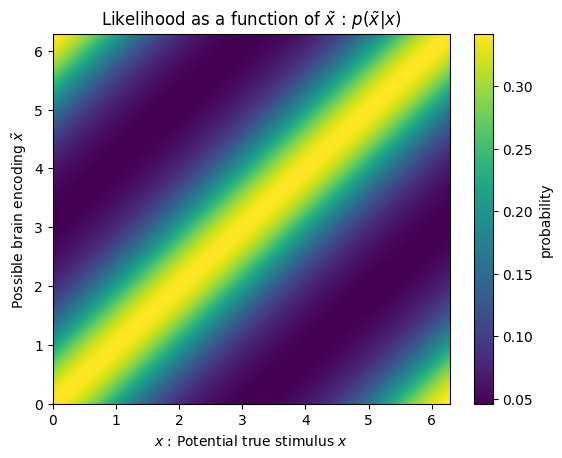

In [31]:
def compute_likelihood_array(x_points, stim_array, kappa=1.0):
    # initializing likelihood_array
    likelihood_array = np.zeros((len(stim_array), len(x_points)))
    # looping over stimulus array

    for i in range(len(x_points)):
        likelihood_array[:, i] = vonmises.pdf(stim_array, kappa=kappa, loc=x_points[i])

    return likelihood_array


likelihood_array = compute_likelihood_array(theta_hyp_array, theta_evidence_array)
plot_myarray(
    likelihood_array,
    "$x$ : Potential true stimulus $x$",
    "Possible brain encoding $\~x$",
    "Likelihood as a function of $\~x$ : $p(\~x | x)$",
)

### Prior array

We first assume that there is only one standard deviation


<>:12: SyntaxWarning: invalid escape sequence '\~'
<>:13: SyntaxWarning: invalid escape sequence '\~'
<>:12: SyntaxWarning: invalid escape sequence '\~'
<>:13: SyntaxWarning: invalid escape sequence '\~'
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_3175/1553687480.py:12: SyntaxWarning: invalid escape sequence '\~'
  'Hypothesized position $x$', 'Brain encoded position $\~x$',
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_3175/1553687480.py:13: SyntaxWarning: invalid escape sequence '\~'
  'Prior as a fcn of $\~x$ : $p(x|\~x)$')


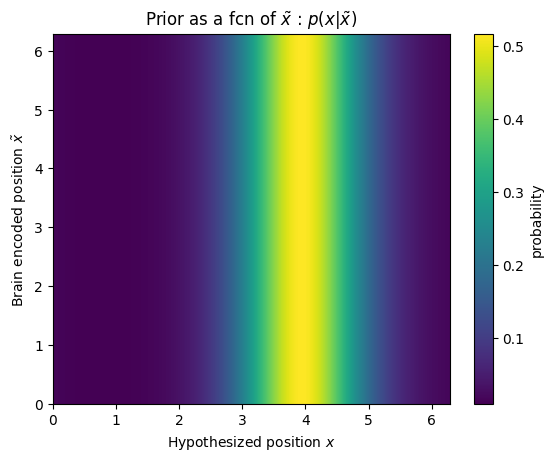

In [42]:
def calculate_prior_array(x_points, stim_array, mean, kappa):
    prior = vonmises.pdf(x_points, kappa=kappa, loc=mean)

    prior_array = np.tile(prior, len(stim_array)).reshape(len(stim_array), -1)

    return prior_array


prior_array = calculate_prior_array(
    theta_hyp_array, theta_evidence_array, mean=get_deg_to_rad(225, False), kappa=2
)
plot_myarray(
    prior_array,
    "Hypothesized position $x$",
    "Brain encoded position $\~x$",
    "Prior as a fcn of $\~x$ : $p(x|\~x)$",
)

### Posterior array


<>:14: SyntaxWarning: invalid escape sequence '\~'
<>:15: SyntaxWarning: invalid escape sequence '\~'
<>:14: SyntaxWarning: invalid escape sequence '\~'
<>:15: SyntaxWarning: invalid escape sequence '\~'
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_3175/2746796389.py:14: SyntaxWarning: invalid escape sequence '\~'
  "Brain encoded Stimulus $\~x$",
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_3175/2746796389.py:15: SyntaxWarning: invalid escape sequence '\~'
  "Posterior as a fcn of $\~x$ : $p(x | \~x)$",


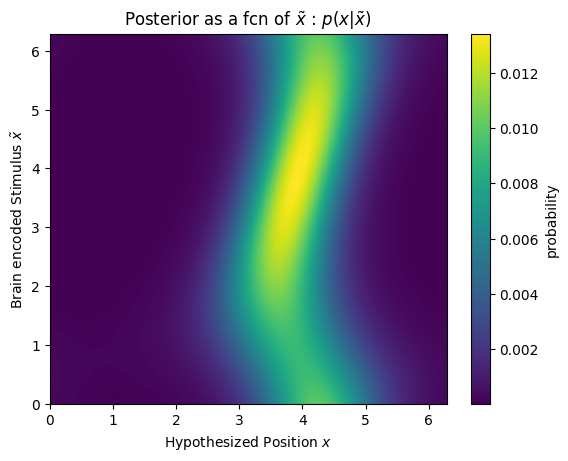

In [36]:
def calculate_posterior_array(prior_array, likelihood_array):
    posterior_array = prior_array * likelihood_array
    posterior_array /= posterior_array.sum(
        axis=1, keepdims=True
    )  # normalize each row separately

    return posterior_array


posterior_array = calculate_posterior_array(prior_array, likelihood_array)
plot_myarray(
    posterior_array,
    "Hypothesized Position $x$",
    "Brain encoded Stimulus $\~x$",
    "Posterior as a fcn of $\~x$ : $p(x | \~x)$",
)

### Estimating the subject percept


<>:18: SyntaxWarning: invalid escape sequence '\h'
<>:19: SyntaxWarning: invalid escape sequence '\~'
<>:18: SyntaxWarning: invalid escape sequence '\h'
<>:19: SyntaxWarning: invalid escape sequence '\~'
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_3175/681454784.py:18: SyntaxWarning: invalid escape sequence '\h'
  "Chosen position $\hat x$",
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_3175/681454784.py:19: SyntaxWarning: invalid escape sequence '\~'
  "Brain-encoded Stimulus $\~ x$",


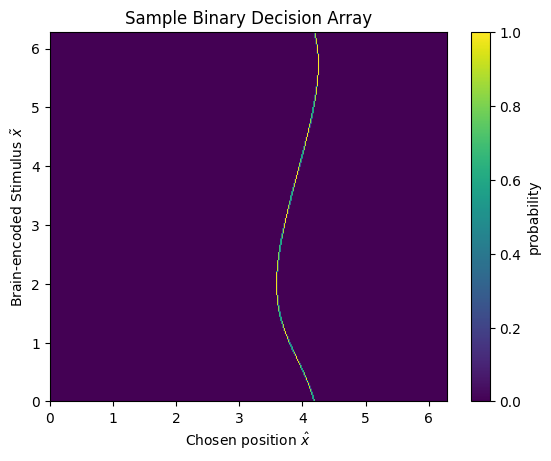

In [37]:
def calculate_binary_decision_array(x_points, posterior_array):
    binary_decision_array = np.zeros_like(posterior_array)

    for i in range(len(posterior_array)):
        mean = np.sum(x_points * posterior_array[i])

        # find the position of mean in x_points (closest position)
        idx = np.argmin(np.abs(x_points - mean))
        # set the cell of the binary decision array to 1
        binary_decision_array[i, idx] = 1

    return binary_decision_array


binary_decision_array = calculate_binary_decision_array(
    theta_hyp_array, posterior_array
)
plot_myarray(
    binary_decision_array,
    "Chosen position $\hat x$",
    "Brain-encoded Stimulus $\~ x$",
    "Sample Binary Decision Array",
)

### Probabilities of subject observations

Here we generate the distribution of theta_e given an actual sensory direction theta_true (not theta_hyp)


<>:14: SyntaxWarning: invalid escape sequence '\~'
<>:15: SyntaxWarning: invalid escape sequence '\~'
<>:14: SyntaxWarning: invalid escape sequence '\~'
<>:15: SyntaxWarning: invalid escape sequence '\~'
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_3175/2726285715.py:14: SyntaxWarning: invalid escape sequence '\~'
  "$\~x$",
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_3175/2726285715.py:15: SyntaxWarning: invalid escape sequence '\~'
  "Sample Distribution over Encodings:\n $p(\~x | x = 2.5)$",


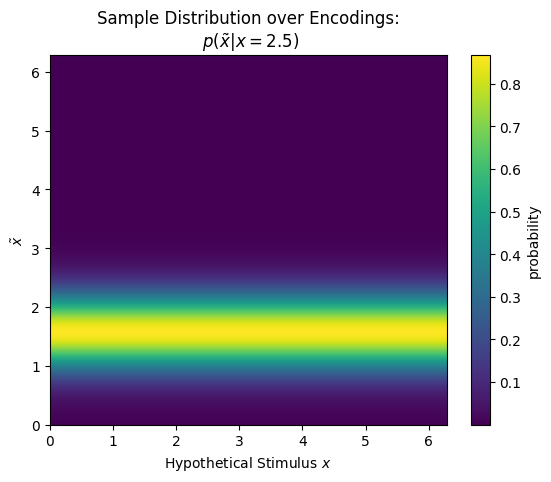

In [44]:
def generate_input_array(x_points, stim_array, posterior_array, mean=2.5, kappa=1.0):
    input_array = np.zeros_like(posterior_array)
    for i in range(len(x_points)):
        input_array[:, i] = vonmises.pdf(stim_array, kappa=kappa, loc=mean)

    return input_array


# Let's just try pi/2 as the actual motion direction
input_array = generate_input_array(
    theta_hyp_array, theta_evidence_array, posterior_array, mean=pi / 2, kappa=5.0
)
plot_myarray(
    input_array,
    "Hypothetical Stimulus $x$",
    "$\~x$",
    "Sample Distribution over Encodings:\n $p(\~x | x = 2.5)$",
)

<>:13: SyntaxWarning: invalid escape sequence '\h'
<>:14: SyntaxWarning: invalid escape sequence '\~'
<>:15: SyntaxWarning: invalid escape sequence '\^'
<>:19: SyntaxWarning: invalid escape sequence '\^'
<>:13: SyntaxWarning: invalid escape sequence '\h'
<>:14: SyntaxWarning: invalid escape sequence '\~'
<>:15: SyntaxWarning: invalid escape sequence '\^'
<>:19: SyntaxWarning: invalid escape sequence '\^'
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_3175/131916026.py:13: SyntaxWarning: invalid escape sequence '\h'
  "estimated $\hat x$",
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_3175/131916026.py:14: SyntaxWarning: invalid escape sequence '\~'
  "$\~x$",
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_3175/131916026.py:15: SyntaxWarning: invalid escape sequence '\^'
  "Marginalization array: $p(\^x | \~x)$",
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_3175/131916026.py:19: SyntaxWarning: invalid escape sequence '\^'
  plt.xlabel("

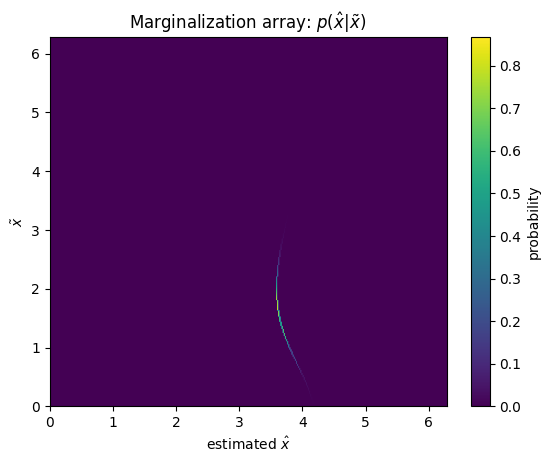

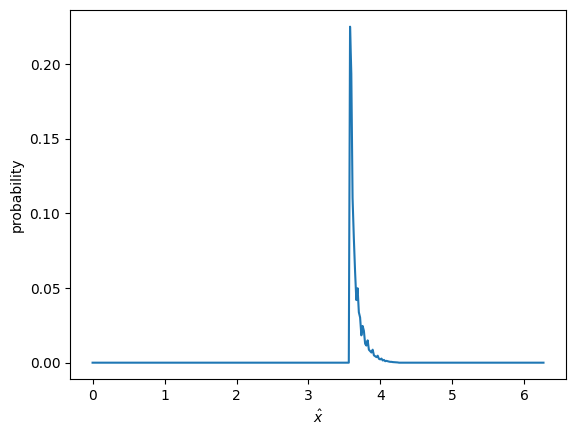

In [46]:
def my_marginalization(input_array, binary_decision_array):
    marginalization_array = input_array * binary_decision_array
    marginal = np.sum(marginalization_array, axis=0)
    marginal /= np.sum(marginal)

    return marginalization_array, marginal


marginalization_array, marginal = my_marginalization(input_array, binary_decision_array)

plot_myarray(
    marginalization_array,
    "estimated $\hat x$",
    "$\~x$",
    "Marginalization array: $p(\^x | \~x)$",
)
plt.figure()
plt.plot(theta_hyp_array, marginal)
plt.xlabel("$\^x$")
plt.ylabel("probability")
plt.show()

### Now, we try to combine all this into one function

Given a single row of data containing the motion coherence, prior std, actual direction, and user estimated direction:

We create the percept distribution using the kappa values corresponding to the motion coherence and prior std.
And then we create the input array using actual direction.

Get the percept distribution, and then calculate maximum likelihood by comparing to the user estimated direction.


Let's try optimizing just a few parameters.
Just filter the data for a single coherence and std value


In [108]:
def generate_input_array(x_points, stim_array, posterior_array, mean, kappa):
    # Using vectorized operations to fill the input_array
    vonmises_values = vonmises.pdf(stim_array[:, None], kappa=kappa, loc=mean)
    input_array = np.tile(vonmises_values, (1, len(x_points)))

    return input_array

In [109]:
def generate_input_array_1(x_points, stim_array, posterior_array, mean, kappa):
    input_array = np.zeros_like(posterior_array)
    for i in range(len(x_points)):
        input_array[:, i] = vonmises.pdf(stim_array, kappa=kappa, loc=mean)

    return input_array

In [97]:
theta_range = np.linspace(0, 2 * pi, 360, endpoint=False)

In [98]:
likelihood_array = np.zeros((len(theta_range), len(theta_range)))

In [110]:
%%timeit
generate_input_array(theta_range, theta_range, likelihood_array, mean=pi / 2, kappa=5.0)

153 μs ± 11.8 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [111]:
%%timeit
generate_input_array_1(
    theta_range, theta_range, likelihood_array, mean=pi / 2, kappa=5.0
)

27.6 ms ± 4.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [130]:
class BayesianModel:
    def __init__(
        self,
        # kappa_e_low,
        # kappa_e_med,
        # kappa_e_high,
        # kappa_prior_low,
        # kappa_prior_med,
        # kappa_prior_high,
        # kappa_prior_high_coh,
        # kappa_m,
        # p_r,
    ):
        # Three likelihood strengths that vary with motion coherence
        # self.kappa_e_low = kappa_e_low
        # self.kappa_e_med = kappa_e_med
        # self.kappa_e_high = kappa_e_high

        # Four prior strengths that vary with experimental prior strength
        # self.kappa_prior_low = kappa_prior_low
        # self.kappa_prior_med = kappa_prior_med
        # self.kappa_prior_high = kappa_prior_high
        # self.kappa_prior_high_coh = kappa_prior_high_coh

        # Motor noise strength
        # self.kappa_m = kappa_m

        # Probability of random estimation (lapse rate)
        # self.p_r = p_r

        # Mean is 225 in radians
        self.prior_mean = get_deg_to_rad(225, False)
        self.theta_range = np.linspace(0, 2 * pi, 360, endpoint=False)

        self.kappa_e_low = 1.0
        self.kappa_prior_low = 2.0
        coherence = 0.06
        prior_std = 10
        likelihood = self.likelihood_array(
            self.theta_range, self.theta_range, self.get_kappa_e(coherence)
        )
        prior = self.prior_array(
            self.theta_range,
            self.theta_range,
            self.prior_mean,
            self.get_kappa_prior(prior_std),
        )
        posterior = self.posterior_array(prior, likelihood)
        binary_decision = self.binary_decision_array(self.theta_range, posterior)
        self.binary_decision = binary_decision

    def get_kappa_e(self, coherence):
        if coherence == 0.06:
            return self.kappa_e_low
        elif coherence == 0.12:
            return self.kappa_e_med
        else:
            return self.kappa_e_high

    def get_kappa_prior(self, prior_std):
        if prior_std == 10:
            return self.kappa_prior_low
        elif prior_std == 20:
            return self.kappa_prior_med
        elif prior_std == 40:
            return self.kappa_prior_high
        else:
            return self.kappa_prior_high_coh

    def likelihood_array(self, x_points, stim_array, kappa_e):
        # initializing likelihood_array
        likelihood_array = np.zeros((len(stim_array), len(x_points)))
        # looping over stimulus array

        for i in range(len(x_points)):
            likelihood_array[:, i] = vonmises.pdf(
                stim_array, kappa=kappa_e, loc=x_points[i]
            )

        return likelihood_array

    def prior_array(self, x_points, stim_array, mean, kappa):
        prior = vonmises.pdf(x_points, kappa=kappa, loc=mean)

        prior_array = np.tile(prior, len(stim_array)).reshape(len(stim_array), -1)

        return prior_array

    def posterior_array(self, prior_array, likelihood_array):
        posterior_array = prior_array * likelihood_array
        posterior_array /= posterior_array.sum(axis=1, keepdims=True)

        return posterior_array

    def binary_decision_array(self, x_points, posterior_array):
        binary_decision_array = np.zeros_like(posterior_array)

        for i in range(len(posterior_array)):
            mean = np.sum(x_points * posterior_array[i])

            # find the position of mean in x_points (closest position)
            idx = np.argmin(np.abs(x_points - mean))
            # set the cell of the binary decision array to 1
            binary_decision_array[i, idx] = 1

        return binary_decision_array

    def generate_input_array(self, x_points, stim_array, posterior_array, mean, kappa):
        vonmises_values = vonmises.pdf(stim_array[:, None], kappa=kappa, loc=mean)
        input_array = np.tile(vonmises_values, (1, len(x_points)))

        return input_array

    def percept_distribution(self, input_array, binary_decision_array):
        marginalization_array = input_array * binary_decision_array
        marginal = np.sum(marginalization_array, axis=0)
        marginal /= np.sum(marginal)

        return marginalization_array, marginal

    # def pre_calculate_decision(self, coherence, prior_std):

    def log_likelihood(self, params, data):
        (
            self.kappa_e_low,
            # self.kappa_e_med,
            # self.kappa_e_high,
            self.kappa_prior_low,
            # self.kappa_prior_med,
            # self.kappa_prior_high,
            # self.kappa_prior_high_coh,
            # self.kappa_m,
            # self.p_r,
        ) = params
        log_prob = 0
        count = 0
        for theta_true, theta_est, coherence, prior_std in data:
            count += 1
            start = time.time()

            # We fit to subject estimates
            # likelihood = self.likelihood_array(
            #     self.theta_range, self.theta_range, self.get_kappa_e(coherence)
            # )
            # prior = self.prior_array(
            #     self.theta_range,
            #     self.theta_range,
            #     self.prior_mean,
            #     self.get_kappa_prior(prior_std),
            # )
            # posterior = self.posterior_array(prior, likelihood)
            # binary_decision = self.binary_decision_array(self.theta_range, posterior)
            input_array = self.generate_input_array(
                self.theta_range,
                self.theta_range,
                # posterior,
                self.binary_decision,
                theta_true,
                self.get_kappa_e(coherence),
            )
            _, estimate_dist = self.percept_distribution(
                input_array, self.binary_decision
            )

            # Find the bin corresponding to theta_est
            est_bin = int(np.round(theta_est / (2 * np.pi) * 360)) % 360
            log_prob += np.log(
                estimate_dist[est_bin] + 1e-10
            )  # Add small constant to avoid log(0)
            end = time.time()
            print(f"Count: {count}, Time taken: {end - start}")
        return -log_prob  # Return negative log-likelihood for minimization

    def fit(self, data):
        # Initial parameter guesses
        # initial_params = [1.0, 2.0, 3.0, 0.5, 1.0, 1.5, 2.0, 1.0, 0.1]
        # initial_params = [1.0, 2.0, 3.0, 0.5, 1.0, 1.5, 2.0]
        initial_params = [1.0, 2.0]

        bounds = [(0, None), (0, None)]

        # Fit the model using maximum likelihood estimation
        result = minimize(
            self.log_likelihood,
            initial_params,
            args=(data,),
            method="Nelder-Mead",
            bounds=bounds,
        )

        (
            self.kappa_e_low,
            # self.kappa_e_med,
            # self.kappa_e_high,
            self.kappa_prior_low,
            # self.kappa_prior_med,
            # self.kappa_prior_high,
            # self.kappa_prior_high_coh,
            # self.kappa_m,
            # self.p_r,
        ) = result.x
        return result.x

    def train(self, df):
        data_for_model = list(
            zip(
                df["motion_direction_rad"],
                df["estimate_angle_rad"],
                df["motion_coherence"],
                df["prior_std"],
            )
        )
        return self.fit(data_for_model)

In [82]:
subject_1 = data[
    (data["subject_id"] == 1)
    & (data["motion_coherence"] == 0.06)
    & (data["prior_std"] == 10)
]

In [131]:
model = BayesianModel()
model.train(subject_1)

Count: 1, Time taken: 0.0003719329833984375
Count: 2, Time taken: 0.0005998611450195312
Count: 3, Time taken: 0.00030803680419921875
Count: 4, Time taken: 0.0002741813659667969
Count: 5, Time taken: 0.0005228519439697266
Count: 6, Time taken: 0.0007541179656982422
Count: 7, Time taken: 0.0007970333099365234
Count: 8, Time taken: 0.000347137451171875
Count: 9, Time taken: 0.0002918243408203125
Count: 10, Time taken: 0.00026607513427734375
Count: 11, Time taken: 0.0002770423889160156
Count: 12, Time taken: 0.0002639293670654297
Count: 13, Time taken: 0.0002560615539550781
Count: 14, Time taken: 0.0003190040588378906
Count: 15, Time taken: 0.0004208087921142578
Count: 16, Time taken: 0.0005228519439697266
Count: 17, Time taken: 0.0004448890686035156
Count: 18, Time taken: 0.0004489421844482422
Count: 19, Time taken: 0.00040602684020996094
Count: 20, Time taken: 0.0003509521484375
Count: 21, Time taken: 0.0002529621124267578
Count: 22, Time taken: 0.0002541542053222656
Count: 23, Time take

array([3.64003906, 0.        ])

In [133]:
kappa_e_low = 3.6400390
kappa_prior_low = 0.00001

<Axes: >

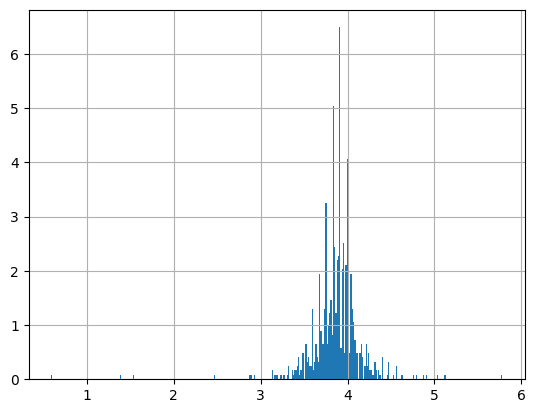

In [139]:
# Plot the prob distribution of subject estimates
subject_1["estimate_angle_rad"].hist(bins=360, density=True)

<>:13: SyntaxWarning: invalid escape sequence '\~'
<>:14: SyntaxWarning: invalid escape sequence '\~'
<>:13: SyntaxWarning: invalid escape sequence '\~'
<>:14: SyntaxWarning: invalid escape sequence '\~'
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_3175/2827566319.py:13: SyntaxWarning: invalid escape sequence '\~'
  "Possible brain encoding $\~x$",
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_3175/2827566319.py:14: SyntaxWarning: invalid escape sequence '\~'
  "Likelihood as a function of $\~x$ : $p(\~x | x)$",


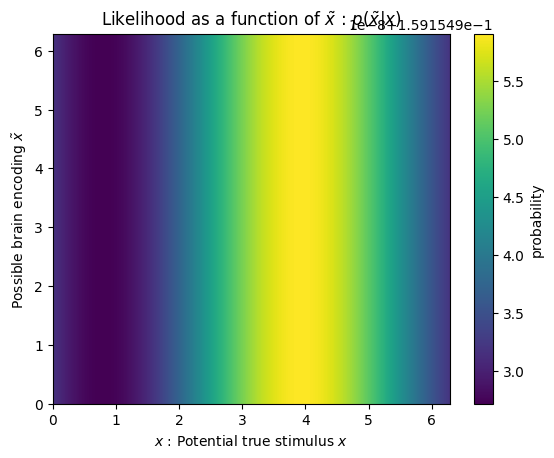

In [129]:
model = BayesianModel()
likelihood = model.likelihood_array(model.theta_range, model.theta_range, kappa_e_low)
prior = model.prior_array(
    model.theta_range, model.theta_range, model.prior_mean, 0.0000001
)
# prior= calculate_prior_array(
#     theta_hyp_array, theta_evidence_array, mean=get_deg_to_rad(225, False), kappa=2
# )

plot_myarray(
    prior,
    "$x$ : Potential true stimulus $x$",
    "Possible brain encoding $\~x$",
    "Likelihood as a function of $\~x$ : $p(\~x | x)$",
)

In [136]:
# Create probability distribution of percepts and also create probability distribution of actual
# User responses so that we can compare


def plot_percept_distribution(
    model, coherence, prior_std, kappa_e, kappa_prior, theta_true
):
    likelihood = model.likelihood_array(model.theta_range, model.theta_range, kappa_e)
    prior = model.prior_array(
        model.theta_range, model.theta_range, model.prior_mean, kappa_prior
    )
    posterior = model.posterior_array(prior, likelihood)
    binary_decision = model.binary_decision_array(model.theta_range, posterior)
    input_array = model.generate_input_array(
        model.theta_range, model.theta_range, binary_decision, theta_true, kappa_e
    )
    _, estimate_dist = model.percept_distribution(input_array, binary_decision)

    plt.figure()
    plt.plot(model.theta_range, estimate_dist)
    plt.xlabel("Estimated $\hat x$")
    plt.ylabel("Probability")
    plt.title("Probability distribution of percepts")
    plt.show()

    return estimate_dist

<>:19: SyntaxWarning: invalid escape sequence '\h'
<>:19: SyntaxWarning: invalid escape sequence '\h'
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_3175/3935883572.py:19: SyntaxWarning: invalid escape sequence '\h'
  plt.xlabel("Estimated $\hat x$")


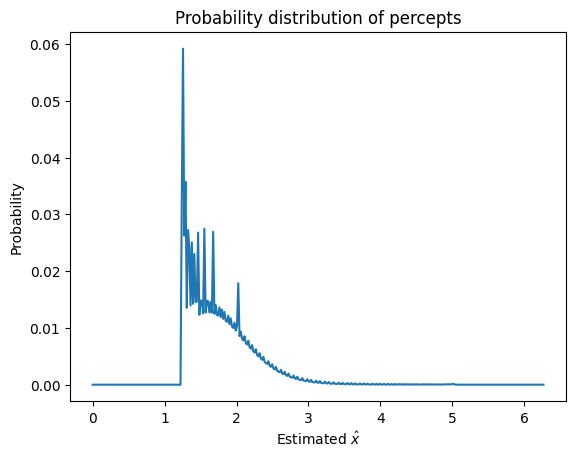

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [135]:
model = BayesianModel()
plot_percept_distribution(
    model,
    0.06,
    10,
    kappa_e_low,
    kappa_prior_low,
)

In [51]:
int(np.round(0.3211406 / (2 * np.pi) * 360)) % 360

18

In [50]:
data["motion_coherence"].unique()

array([0.12, 0.06, 0.24])

In [68]:
def objective_function(x):
    return (x - 3) ** 2


x0 = 0  # Initial guess

In [69]:
result = minimize(objective_function, x0, method="BFGS")
result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.5388963550532293e-16
        x: [ 3.000e+00]
      nit: 2
      jac: [-1.697e-08]
 hess_inv: [[ 5.000e-01]]
     nfev: 6
     njev: 3

We can try reducing the problem down to its bare bones.
Just focus on one coherence and one standard deviation.
Then compare the shapes of the learnt outputs.
